In [1]:
%matplotlib inline
import math

import numpy as np
import time
import matplotlib.pyplot as plt

from tools.corner_response_function import convolve, compute_corner_response, difference_of_Gaussian_filters
from tools.visualization import reshape_as_images, imshow
from tools.data_loading import load_images
from tools.discretization import discretize_orientation, pin_as_vect
from tools.quantization import kmeans, vf_vector

In [2]:
filter_size = 3

In [3]:
X = load_images(type="train")
X = reshape_as_images(X) # 5000 x 32 x 32 x 3
images = X.mean(axis=3) # 5000 x 32 x 32
window_size = 5
stride = 3
patch_size = 5

filterx, filtery = difference_of_Gaussian_filters()

R_size = (images.shape[1] - window_size - filter_size)//stride + 1
R = np.zeros((images.shape[0], R_size, R_size))
grads = list()

In [4]:
for image_idx in range(images.shape[0]):
        image_mat = images[image_idx]
        im_size = image_mat.shape[0]  # normally 32
        image_grad_x, image_grad_y = convolve(image_mat, filterx, filtery)
        grads.append((image_grad_x, image_grad_y))
        for i in range(R_size):
            for j in range(R_size):
                I_x = image_grad_x[i*stride:i*stride+window_size,
                                   j*stride:j*stride+window_size]
                I_y = image_grad_y[i*stride:i*stride+window_size,
                                   j*stride:j*stride+window_size]

                R[image_idx, i, j] = compute_corner_response(I_x, I_y)
        # thresholding of R
        R[image_idx] = np.abs(R[image_idx])

In [5]:
def from_R_to_im(x, y, window_size, stride):
    x = x * stride + (window_size - 1)//2 + (filter_size - 1)//2
    y = y * stride + (window_size - 1)//2 + (filter_size - 1)//2

    return (x, y)


def R_to_heatmap(R, window_size, stride, im_size):
    R_size = R.shape[0]
    # create heatmap
    heatmap = np.zeros((im_size, im_size))
    for i in range(R_size):
        for j in range(R_size):
            ix, iy = from_R_to_im(i, j, window_size, stride)
            heatmap[ix:ix+window_size,
                    iy:iy+window_size] = R[i, j]
    heatmap /= heatmap.max()
    return heatmap

In [6]:
ind = 0

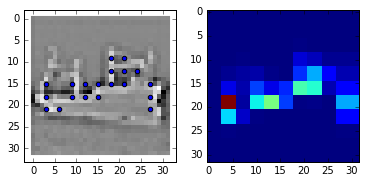

In [7]:
i, j = np.where(R[ind] > np.percentile(R[ind], 75))
i, j = from_R_to_im(i, j, window_size, stride)

x, y = j, i

heatmap = R_to_heatmap(R[ind], window_size, stride, im_size)
imshow(images[ind], points_of_interest=(x, y), heatmap=heatmap)
ind +=1

# Dataset separation

In [8]:
n_train = X.shape[0]
sep_indices = np.random.permutation(X.shape[0])
training_idx, test_idx = sep_indices[:int(0.9*n_train)], sep_indices[int(0.9*n_train):]

In [9]:
pins_img_ids = []
pins_coords = []
train_pins = list()
im_to_pins = dict.fromkeys(range(images.shape[0]), [])
pin_to_im = dict() # size is preallocated with the actual number of pin per img 
pins = list()
for image_idx in range(images.shape[0]):
    image_mat = images[image_idx]
    i_s, j_s = np.where(
        R[image_idx] > np.percentile(R[image_idx], 75))
    i_s, j_s = from_R_to_im(i_s, j_s, window_size, stride)
    image_grad_x, image_grad_y = grads[image_idx]
    for i, j in zip(i_s, j_s):  # i, j are the coordinates in R of POI
        patch_x = image_grad_x[i-patch_size//2:i+patch_size//2+1,
                               j-patch_size//2:j+patch_size//2+1]
        patch_y = image_grad_y[i-patch_size//2:i+patch_size//2+1,
                               j-patch_size//2:j+patch_size//2+1]
        pin_as_matrix = discretize_orientation(patch_x, patch_y)
        pin = pin_as_vect(pin_as_matrix)
        pins.append(pin) # pins is list of all pins for all images
        # for visualization purposes
        pins_img_ids.append(image_idx)
        pins_coords.append((i,j))
        im_to_pins[image_idx].append(pin)
        pin_to_im[len(pins)-1] = image_idx
        if image_idx in training_idx:
            train_pins.append(pin)

In [10]:
pins_mat = np.vstack(train_pins)

In [11]:
visual_features = kmeans(pins_mat, 70)

88497
32773
16830
11343
8596
6849
5728
5021
4405
3826
3471
3222
3035
2895
2757
2548
2460
2191
2102
1920
1747
1597
1461
1342
1282
1287
1157
1143
1102
975
916
930
887
843
831
797
814
817
781
721
719
705
698
668
680
646
560
555
554
551
547
537
522
543
499
514
480
507
493
468
462
476
496
459
441
409
399
388
370
334
325
310
288
303
302
325
258
263
263
223
257
237
247
227
248
226
209
219
192
170
185
188
192
183
204
227
239
237
242
272
250
244
241
230
231
234
230
223
218
224
245
245
214
197
176
170
180
178
178
177
163
155
165
160
134
133
140
161
163
174
165
181
173
160
157
156
168
160
152
118
132
143
152
143
170
179
177
170
177
200
182
183
167
177
162
154
152
153
158
159
160
163
164
179
194
204
215
192
145
152
128
111
123
135
131
117
119
120
114
119
119
112
115
102
119
126
121
119
109
127
115
111
103
109
110
115
125
122
131
107
103
103
97
87
77
68
63
59
64
74
74
94
117
130
120
127
120
99
92
103
93
75
68
68
74
80
87
84
77
91
112
112
113
116
114
97
97
119
96
127
128
115
137
114
118
153
124
116


In [12]:
vf_vector(train_pins, visual_features)

array([ 1312.,  1239.,  1520.,  1258.,  1471.,  1336.,   741.,  1240.,
        1272.,  1258.,  1486.,  1276.,  1403.,  1498.,  1342.,  1276.,
        1441.,  1367.,  1172.,  1586.,  1296.,  1362.,   794.,  1284.,
        1482.,  1494.,  1182.,  1551.,  1366.,  1509.,  1313.,  1307.,
        1021.,  1310.,  1259.,  1464.,  1252.,  1372.,  1405.,  1315.,
        1373.,  1290.,  1527.,  1141.,   995.,  1361.,  1458.,  1269.,
        1311.,  1110.,  1094.,   687.,   978.,   983.,  1347.,  1439.,
        1377.,  1286.,  1407.,  1305.,  1338.,  1281.,  1107.,  1236.,
        1457.,  1413.,  1093.,  1200.,  1107.,  1198.])

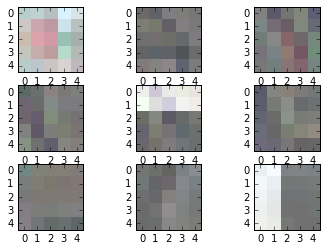

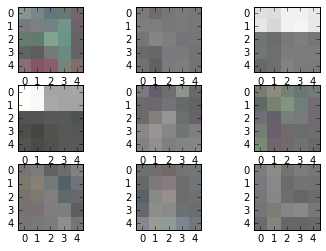

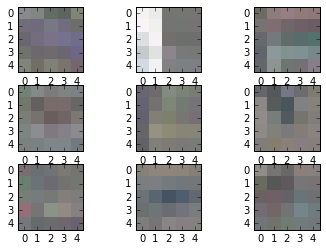

In [13]:
y = np.argmin(np.linalg.norm(pins_mat[:, None, :] - visual_features, axis=2), axis=1)


nb_features = 3
for i in range(nb_features): # first three visual features
    indices = np.where(y == i)[0][:9]
    f, axarr = plt.subplots(3, 3)
    
    for aa in range(9):
        r = aa // 3
        s = aa - r * 3
        ii, jj = pins_coords[indices[aa]]
        image = X[pins_img_ids[indices[aa]]][ii-patch_size//2:ii+patch_size//2+1,
                               jj-patch_size//2:jj+patch_size//2+1]
        image -= X[pins_img_ids].min()
        image /= X[pins_img_ids].max()
        axarr[r,s].imshow(image, interpolation="nearest")

# Actual pipeline

In [14]:
from tools.data_loading import load_images, load_labels, dummy_code
from tools.visualization import imshow, dump_as_png
from tools.submission import labels_to_csv
from tools.kernels import kernel_matrix
from tools.process_images import process_images
from tools.optimization import find_f
from tools.prediction import pred

In [15]:
def vf_vector_note(pins, centroids, pin_to_im,n_train):
    '''Assigns each element of pins (points of interest for one image) to the
    closest centroid (VF).
        Args:
            - pins (list): the points of interest
            - centroids (ndarray): the visual features
            - pin_to_im: dict
        Output:
            - ndarray: the visual features vector
    '''
    k = centroids.shape[0]
    vf_vector = np.zeros((n_train, k))
    pins = np.vstack(pins)

    y = np.argmin(np.linalg.norm(pins[:, None, :] - centroids, axis=2), axis=1)

    for idx, pin in enumerate(pins):
        y_pin = y[idx]
        vf_vector[pin_to_im[idx], y_pin] += 1
    return vf_vector

In [31]:
#from tools.quantization import vf_vector


def process_images_note(X, proc_type="identity", **kwargs):
    '''Vectorize the features of each images contained in the rows of X.
    '''
    if proc_type == "identity":
        return X
    elif proc_type == "bovf":
        try:
            centroids = kwargs["centroids"]
        except KeyError:
            raise KeyError("You need centroids for bovf")
        else:
            try:
                im_to_pins = kwargs["im_to_pins"]
            except KeyError:
                raise KeyError("You need im_to_pins for bovf")
            else:
                try:
                    pin_to_im = kwargs["pin_to_im"]
                except KeyError:
                    raise KeyError("You need pin_to_im for bovf")
                else:
                    n = X.shape[0]
                    X_proc = np.zeros((n, centroids.shape[0]))
                    X_proc = vf_vector_note(pins_test, centroids,pin_to_im,n)
                    return X_proc
    else:
        raise ValueError("{} is not an image processing".format(proc_type))

In [17]:
Y_labels_train = load_labels()
Y_train = dummy_code(Y_labels_train)
n_classes = Y_train.shape[1]

X_proc = process_images_note(X, proc_type="bovf", centroids=visual_features, im_to_pins=im_to_pins,pin_to_im=pin_to_im)
n_train, n_var = X_proc.shape
X_sample = X_proc[training_idx, :]
n_sample = X_sample.shape[0]
X_test = X_proc[test_idx, :]
n_test = X_test.shape[0]
Y_sample = Y_train[training_idx, :]

In [18]:
# Training
kernel_type = "linear"
K_sample = kernel_matrix(X_sample, kernel_type=kernel_type)

classifier_type = "linear regression"
alpha = np.zeros((n_classes, n_sample))
for dig in range(n_classes):
    alpha[dig, :] = find_f(K_sample, Y_sample[:, dig],
                           prob_type=classifier_type, lamb=1.0)

# Evaluation
Y_pred = np.zeros((X_test.shape[0], n_classes))
for dig in range(n_classes):
    Y_pred[:, dig] = pred(X_sample, X_test, alpha[dig, :],
                          kernel_type=kernel_type)


Y_labels_pred = np.argmax(Y_pred, axis=1)
prec = np.mean(Y_labels_pred == Y_labels_train[test_idx])
print(prec)

0.252


# Submission

In [19]:
X_test = load_images(type="test")
X_test = reshape_as_images(X_test) # 5000 x 32 x 32 x 3
images_test = X_test.mean(axis=3) # 5000 x 32 x 32

R_test = np.zeros((images_test.shape[0], R_size, R_size))

In [20]:
for image_idx in range(images_test.shape[0]):
        image_mat = images_test[image_idx]
        im_size = image_mat.shape[0]  # normally 32
        image_grad_x, image_grad_y = compute_gaussian_grad(image_mat)
        for i in range(R_size):
            for j in range(R_size):
                I_x = image_grad_x[i*stride:i*stride+window_size,
                                   j*stride:j*stride+window_size]
                I_y = image_grad_y[i*stride:i*stride+window_size,
                                   j*stride:j*stride+window_size]

                R_test[image_idx, i, j] = compute_corner_response(I_x, I_y)
        # thresholding of R
        R_test[image_idx] = np.abs(R_test[image_idx])

In [26]:
im_to_pins_test = dict.fromkeys(range(images_test.shape[0]), [])
pin_to_im_test = dict() # size is preallocated with the actual number of pin per img 
pins_test = list()
for image_idx in range(images_test.shape[0]):
    image_mat = images_test[image_idx]
    i_s, j_s = np.where(
        R_test[image_idx] > np.percentile(R_test[image_idx], 75))
    i_s, j_s = from_R_to_im(i_s, j_s, window_size, stride)
    image_grad_x, image_grad_y = compute_gaussian_grad(image_mat) # added with Pierre ????
    for i, j in zip(i_s, j_s):  # i, j are the coordinates in R of POI
        patch_x = image_grad_x[i-patch_size//2:i+patch_size//2+1,
                               j-patch_size//2:j+patch_size//2+1]
        patch_y = image_grad_y[i-patch_size//2:i+patch_size//2+1,
                               j-patch_size//2:j+patch_size//2+1]
        pin_as_matrix = discretize_orientation(patch_x, patch_y)
        pin = pin_as_vect(pin_as_matrix)
        pins_test.append(pin) # pins is list of all pins for all images
        im_to_pins_test[image_idx].append(pin)
        pin_to_im_test[len(pins_test)-1] = image_idx

In [30]:
len(pins_test)

40000

In [32]:
X_test_proc = process_images_note(X_test, proc_type="bovf",
                                  centroids=visual_features, im_to_pins=im_to_pins_test,pin_to_im=pin_to_im_test)
n_eval = X_test_proc.shape[0]
Y_eval = np.zeros((n_eval, n_classes))
for dig in range(n_classes):
    Y_eval[:, dig] = pred(X_sample, X_test_proc, alpha[dig, :],
                          kernel_type=kernel_type)


Y_labels_eval = np.argmax(Y_eval, axis=1)




FileNotFoundError: [Errno 2] No such file or directory: 'submissions/Yte_linear_linear regression_Zac.csv'

In [33]:
# Submission
labels_to_csv(Y_labels_eval, user="Pierre")

In [24]:
X_test_proc.shape

(2000, 32, 32, 3)